In [1]:
import time
import numpy as np
import scipy.interpolate as ip
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
SIZE = 5
MAX = 100

In [205]:
x = np.random.rand(SIZE) * MAX
y = np.random.rand(SIZE) * MAX
display(x, y)

array([61.74137569, 40.95997402, 22.74151601, 82.85679589, 45.83718844])

array([24.63874464, 83.74209807,  2.71344724, 53.61043903, 48.40252907])

In [5]:
def e2latex(e):
    if(e.find('e') == -1):
        return e
    [a, b] = e.split('e')
    return f'({a}\cdot 10^{{{b}}})'

def poly2latex(p):
    terms = []
    if len(p) > 2:
        for i in range(2, len(p)):
            ii = len(p) - i + 1
            term = 'x^{%d}' % ii
            c = p.coef[ii]
            if c!=1:
                cc = '%.2g ' % c
                term = e2latex(cc) + term
            terms.append(term)
    if len(p) > 1:
        term = 'x'
        c = p.coef[1]
        if c!=1:
            cc = '%.2g ' % c
            term = e2latex(cc) + term
        terms.append(term)
    cc = '%.2g' % p.coef[0]
    terms.append(e2latex(cc))
    px = '$P(x)=%s$' % '+'.join(terms)
    px = px.replace('+-', '-')
    return px

def display_poly(poly):
    p = np.polynomial.Polynomial(poly.c[::-1])
    display(Latex(poly2latex(p)))

def plot_poly(pd, xs, ys):
    plot_polys([pd], xs, ys)

def plot_polys(plist, xs, ys):
    t = np.linspace(0, MAX, 500)
    figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
    for (p, desc) in plist:
        plt.plot(t, p(t), label=desc)
    plt.scatter(xs, ys, label="Sample")
    plt.legend(bbox_to_anchor=(0., -.200, 1., .200), loc=10, ncol=5)
    plt.xlabel('$x$')
    plt.ylabel('$P(x)$')

## Interplacja Lagrenge'a

Wielomian interpolacyjny Lagrange'a:
$$P_n(x)=\sum_{j=1}^{n}\Bigg(y_j\prod_{\substack{k=1\\k\neq j}}^n\frac{x-x_k}{x_j-x_k}\Bigg)$$

In [230]:
def my_lagrange(x, y):
    assert x.size == y.size
    result = np.poly1d(0)
    for j in range(x.size):
        result += my_lagrange_Pj(x, y, j)
    return result

def my_lagrange_Pj(x, y, j):
    p = np.poly1d([1,0])
    d = np.poly1d(1)
    m = 1.0
    for k in range(x.size):
        if(k == j):
            continue
        d *= p - x[k]
        m *= x[j] - x[k]
    return y[j]*(d/m)

In [208]:
p_my_lagrange = my_lagrange(x, y)
p_lagrange = ip.lagrange(x, y)

display_poly(p_lagrange)
display_poly(p_my_lagrange)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

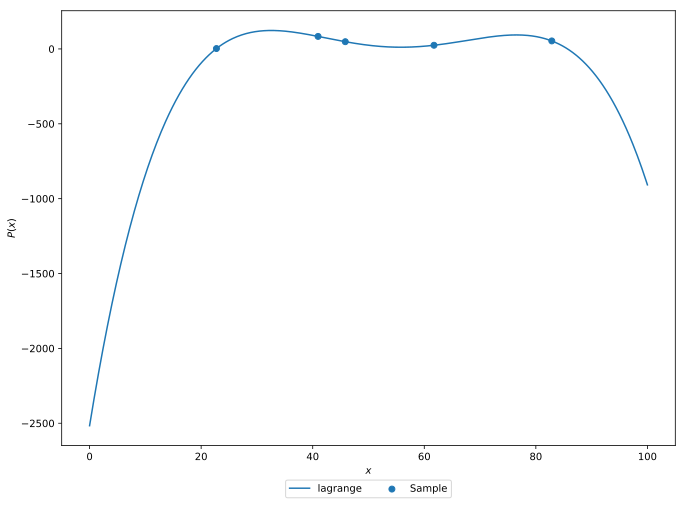

In [669]:
plot_poly((p_my_lagrange, "lagrange"), x, y)

## Interpolacja Newtona

Wielomian interpolacyjny Newtona:
$$P_n(x)=\sum_{i=0}^{n}\Bigg(a_i\prod_{j=0}^{i-1}\big(x-x_j\big)\Bigg)$$
gdzie:
$$a_i=f[x_0, x_1, ..., x_i]$$

In [8]:
def newton_coef(x, y):
    n = x.size
    a = np.empty(n)
    for i in range(n):
        a[i] = y[i]
    for j in range(1, n):
        for i in range(n-1, j-1, -1):
            a[i] = (a[i] - a[i-1])/(x[i] - x[i-j])
    return a

def my_newton(x, y):
    assert x.size == y.size
    n = x.size
    a = newton_coef(x, y)
    result = np.poly1d(0)
    for i in range(n):
        p = np.poly1d(1)
        for j in range(i):
            p *= np.poly1d(x[j], True)
        result += a[i] * p
    return result

In [409]:
p_my_newton = my_newton(x, y)

display_poly(p_my_newton)

<IPython.core.display.Latex object>

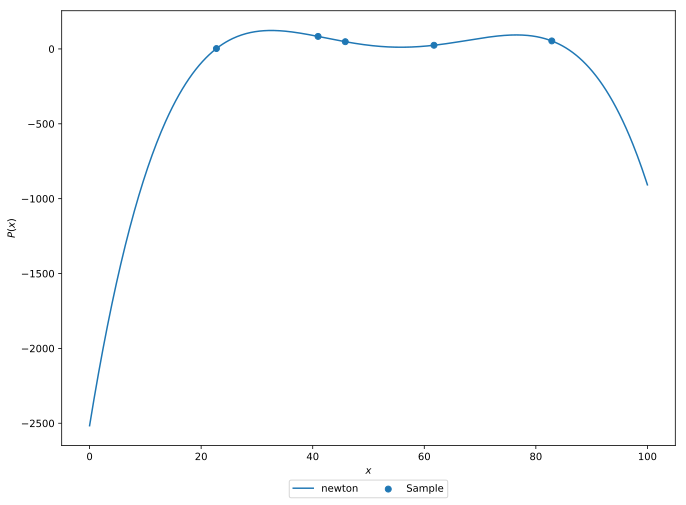

In [670]:
plot_poly((p_my_newton, "newton"), x, y)

## Biblioteczna implementacja interpolacji
(za pomocą krzywych sklejanych drugiego stopnia)

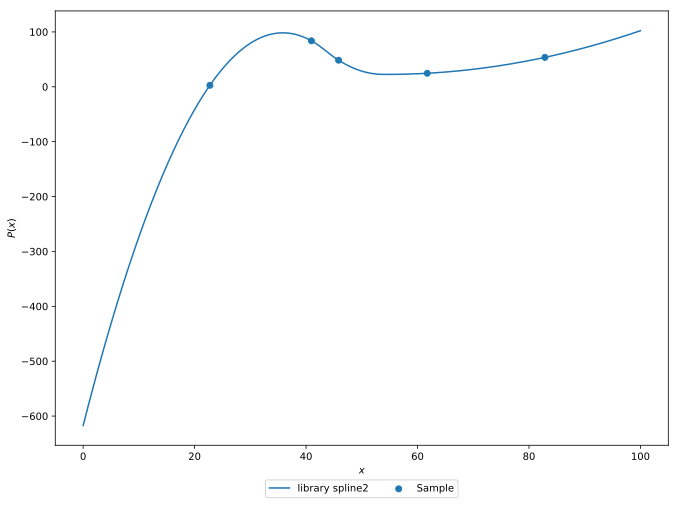

In [671]:
p_lib_interp = ip.interp1d(x, y, fill_value="extrapolate", kind="quadratic")

plot_poly((p_lib_interp, "library spline2"), x, y)

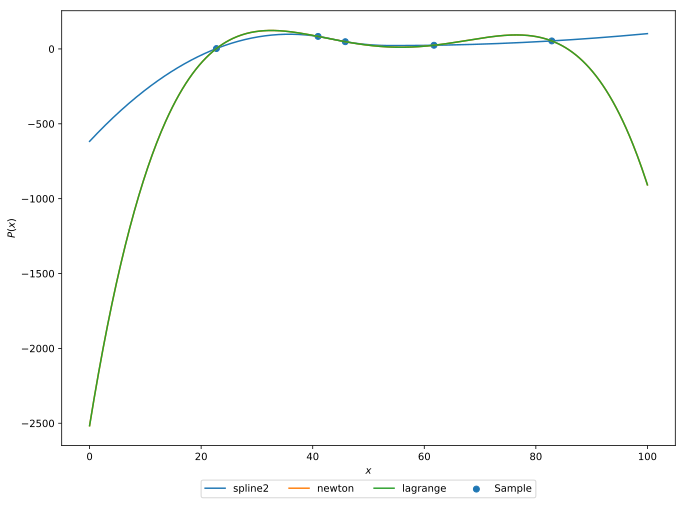

In [672]:
plot_polys([(p_lib_interp, "spline2"), (p_my_newton, "newton"), (p_my_lagrange, "lagrange")], x, y)

## Funkcje sklejane

In [529]:
p_2spline = ip.interp1d(x, y, fill_value="extrapolate", kind="quadratic")
p_3spline = ip.interp1d(x, y, fill_value="extrapolate", kind="cubic")

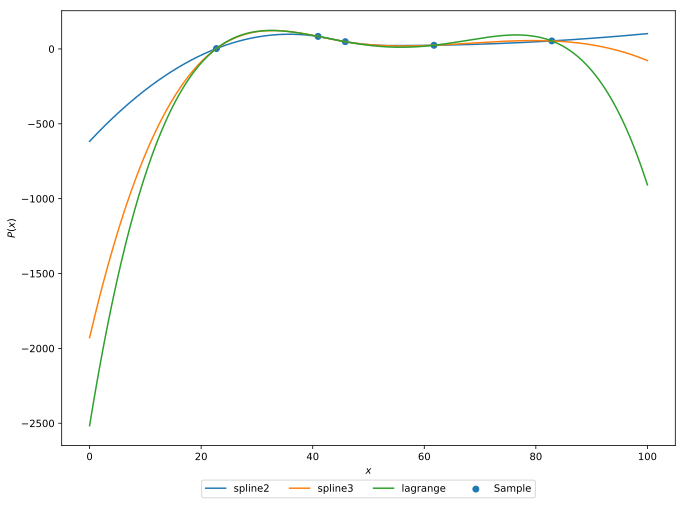

In [673]:
plot_polys([(p_2spline, "spline2"), (p_3spline, "spline3"), (p_my_lagrange, "lagrange")], x, y)

## Czasy obliczeń

In [531]:
def measure_my_lagrange(x, y):
    start = time.perf_counter_ns()
    my_lagrange(x, y)
    end = time.perf_counter_ns()
    return end - start

def measure_my_newton(x, y):
    start = time.perf_counter_ns()
    my_newton(x, y)
    end = time.perf_counter_ns()
    return end - start

def measure_quadratic(x, y):
    start = time.perf_counter_ns()
    ip.interp1d(x, y, fill_value="extrapolate", kind="quadratic")
    end = time.perf_counter_ns()
    return end - start

def measure_cubic(x, y):
    start = time.perf_counter_ns()
    ip.interp1d(x, y, fill_value="extrapolate", kind="cubic")
    end = time.perf_counter_ns()
    return end - start

def measure_lagrange(x, y):
    start = time.perf_counter_ns()
    ip.lagrange(x, y)
    end = time.perf_counter_ns()
    return end - start

In [648]:
df = pd.DataFrame(columns=['type', 'n', 'time'])

test_count = 10
points = range(4, 31)
for i in range(test_count):
    for n in points:
        xx = np.random.rand(n) * MAX
        yy = np.random.rand(n) * MAX
        df.loc[len(df)] = ['my_lagrange', n, float(measure_my_lagrange(xx, yy))]
        df.loc[len(df)] = ['my_newton', n, float(measure_my_newton(xx, yy))]
        df.loc[len(df)] = ['spline2', n, float(measure_quadratic(xx, yy))]
        df.loc[len(df)] = ['spline3', n, float(measure_cubic(xx, yy))]
        df.loc[len(df)] = ['lagrange', n, float(measure_lagrange(xx, yy))]

display(df.head(), df.tail())

,type,n,time
0,my_lagrange,4,2666500.0
1,my_newton,4,621700.0
2,spline2,4,442500.0
3,spline3,4,597300.0
4,lagrange,4,699500.0


,type,n,time
1345,my_lagrange,30,45464100.0
1346,my_newton,30,26262300.0
1347,spline2,30,295200.0
1348,spline3,30,303700.0
1349,lagrange,30,35497700.0


In [649]:
aggregated = df.groupby(['type', 'n'], as_index=False).agg(['mean', 'sem']).reset_index()
aggregated['mean'] = aggregated.time['mean']
aggregated['serr'] = aggregated.time['sem']
aggregated.drop('time', level=0, axis=1, inplace=True)
aggregated

,type,n,mean,serr
,,,,
0,lagrange,4,738470.0,9.305372e+04
1,lagrange,5,1125660.0,1.377599e+05
2,lagrange,6,1421080.0,7.508160e+04
3,lagrange,7,2034860.0,2.146058e+05
4,lagrange,8,2788850.0,2.892664e+05
5,lagrange,9,3654320.0,4.693349e+05
6,lagrange,10,4500090.0,5.349104e+05
7,lagrange,11,5566500.0,4.696283e+05
8,lagrange,12,6486290.0,8.006597e+05


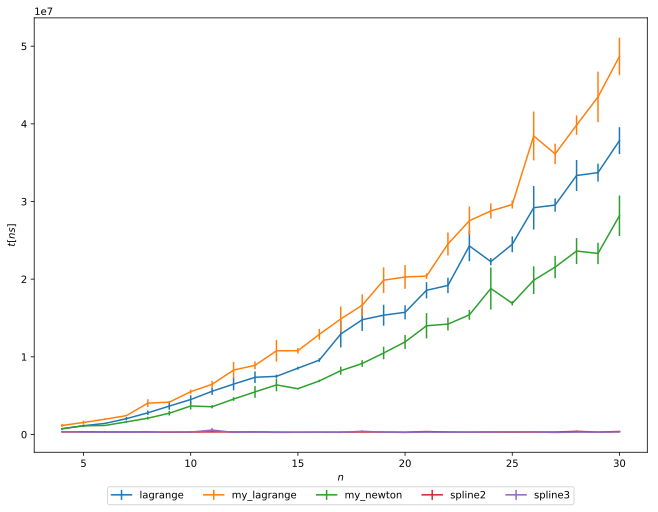

In [674]:
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
for typee in aggregated.type.unique():
    vdf = aggregated[aggregated.type == typee]
#     plt.plot(vdf['n'].values, vdf['mean'].values, label=typee)
    plt.errorbar(vdf['n'].values, vdf['mean'].values, yerr=vdf['serr'].values, label=typee)
plt.legend(bbox_to_anchor=(0., -.200, 1., .200), loc=10, ncol=5)
plt.xlabel('$n$')
plt.ylabel('$t[ns]$')
plt.show()

## Efekt Rungego

array([ 9.09090909, 18.18181818, 27.27272727, 36.36363636, 45.45454545,
       54.54545455, 63.63636364, 72.72727273, 81.81818182, 90.90909091])

array([36.20785889, 49.90876599, 66.24533513, 90.77271113, 24.36432586,
       24.15456288,  6.137739  , 29.83077774, 51.34712218, 24.64196059])

(-100, 200)

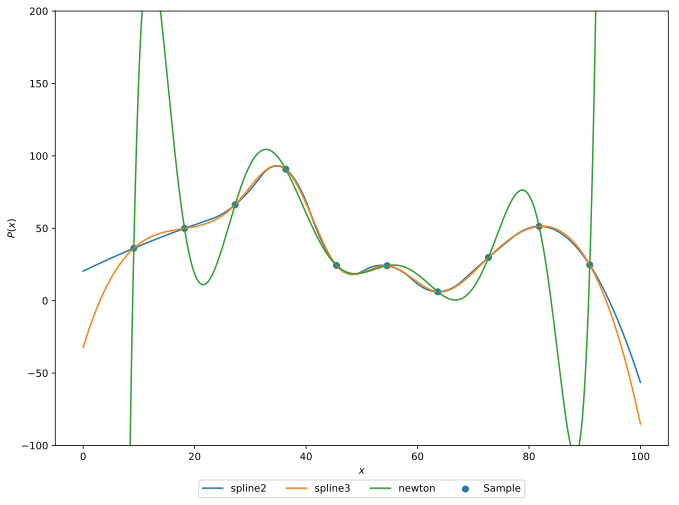

In [18]:
SIZEb = 10
xb = np.array([i * (MAX / (SIZEb + 1)) for i in range(1, SIZEb + 1)])
yb = np.random.rand(SIZEb) * MAX
display(xb, yb)

p_2spline2 = ip.interp1d(xb, yb, fill_value="extrapolate", kind="quadratic")
p_3spline2 = ip.interp1d(xb, yb, fill_value="extrapolate", kind="cubic")
p_my_newton2 = my_newton(xb, yb)
plot_polys([(p_2spline2, "spline2"), (p_3spline2, "spline3"), (p_my_newton2, "newton")], xb, yb)
plt.ylim(-100, 200)